# Imports and installations

In [ ]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 21.5 MB/s eta 0:00:00


In [ ]:
# !pip install netCDF4 h5netcdf

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker

from cartopy.util import add_cyclic_point
from matplotlib import animation
from tqdm.auto import tqdm
from datetime import datetime,timedelta

In [ ]:
import  xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
import warnings
import math
from tqdm.auto import tqdm
from tqdm.auto import tqdm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Daily maximums caclulation


In [ ]:
# Taking the masked data for defining HW over BD only
ds_ept=xr.open_dataset('/content/drive/MyDrive/AP_HW/Scripts-ll/HW_dates/data/ept_bdt_masked.nc')
ds_t2m=xr.open_dataset('/content/drive/MyDrive/AP_HW/Scripts-ll/HW_dates/data/t2m_bdt_masked.nc')

In [ ]:
# ds_ept

In [ ]:
# ds_t2m

In [ ]:
ds_ept_daily_max=ds_ept.ept.resample(time='D').max()
ds_t2m_daily_max=ds_t2m.t2m.resample(time='D').max()



In [ ]:
# ds_ept_daily_max

In [ ]:
# ds_t2m_daily_max

# Rolling Threshold calculation


In [ ]:
# Remove leap day (Feb 29)
max_t2m = ds_t2m_daily_max.sel(time=~((ds_t2m_daily_max.time.dt.month == 2) & (ds_t2m_daily_max.time.dt.day == 29)))
# max_t2m
max_ept = ds_ept_daily_max.sel(time=~((ds_ept_daily_max.time.dt.month == 2) & (ds_ept_daily_max.time.dt.day == 29)))
# max_ept

In [ ]:
# Select T2M data for years 1981–2010
max_t2m_copy = max_t2m.sel(time=max_t2m.time.dt.year.isin(range(1981,2011)))
# Add day-of-year (DOY) coordinate
max_t2m_copy['doy'] = max_t2m_copy['time'].dt.dayofyear
max_t2m_copy

# Select T2M data for years 1981–2010
max_ept_copy = max_ept.sel(time=max_ept.time.dt.year.isin(range(1981,2011)))
# Add day-of-year (DOY) coordinate
max_ept_copy['doy'] = max_ept_copy['time'].dt.dayofyear
max_ept_copy

<xarray.DataArray 'ept' (time: 10950, latitude: 24, longitude: 19)> Size: 40MB
array([[[         nan, 323.5558911 , 324.21204085, ...,          nan,
                  nan,          nan],
        [         nan, 323.55642433, 323.81375784, ...,          nan,
                  nan,          nan],
        [322.99862911, 322.98698492, 322.3532032 , ...,          nan,
                  nan,          nan],
        ...,
        [         nan,          nan,          nan, ..., 326.0802169 ,
         326.63998527, 326.79354799],
        [         nan,          nan,          nan, ...,          nan,
         325.46427388,          nan],
        [         nan,          nan,          nan, ...,          nan,
         329.95991815,          nan]],

       [[         nan, 323.01018623, 322.48133397, ...,          nan,
                  nan,          nan],
        [         nan, 324.24454751, 324.29934334, ...,          nan,
                  nan,          nan],
        [323.12144848, 323.4640473 , 323.5931968 , ...,          nan,
                  nan,          nan],
...
        [         nan,          nan,          nan, ..., 329.77401272,
         332.28286149, 336.47265866],
        [         nan,          nan,          nan, ...,          nan,
         329.33157222,          nan],
        [         nan,          nan,          nan, ...,          nan,
         328.48039824,          nan]],

       [[         nan, 324.83700768, 324.56067853, ...,          nan,
                  nan,          nan],
        [         nan, 323.4970152 , 325.17456975, ...,          nan,
                  nan,          nan],
        [324.69384916, 324.13976842, 323.90427891, ...,          nan,
                  nan,          nan],
        ...,
        [         nan,          nan,          nan, ..., 329.94713558,
         332.93798471, 335.88473164],
        [         nan,          nan,          nan, ...,          nan,
         329.20137413,          nan],
        [         nan,          nan,          nan, ...,          nan,
         328.68752598,          nan]]])
Coordinates:
  * latitude   (latitude) float32 96B 26.5 26.25 26.0 25.75 ... 21.25 21.0 20.75
  * longitude  (longitude) float32 76B 88.0 88.25 88.5 88.75 ... 92.0 92.25 92.5
  * time       (time) datetime64[ns] 88kB 1981-01-01 1981-01-02 ... 2010-12-31
    doy        (time) int64 88kB 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
Attributes:
    units:      K
    long_name:  Equivalent potential temperature

In [ ]:
# Loop through 351 days (sliding 15-day windows)

t2m_day_group=max_t2m_copy.groupby('doy')
t2m_percentile_list=[]
for i in range(351):
  # Combine data from a 15-day window
  combined = xr.concat([t2m_day_group[d] for d in range(i+1,i+16)], dim="time")
  # Calculate 95th percentile for each grid cell
  percentile_95 = combined.quantile(0.95, dim="time")
  # Assign corresponding DOY (centered at i+8)
  percentile_95 = percentile_95.assign_coords(doy=8+i)
  # Convert to dataset format
  percentile_95 = percentile_95.to_dataset()
  # Append to list
  t2m_percentile_list.append(percentile_95)

# Concatenate results into a single dataset along DOY dimension
t2m_percentile_doy = xr.concat(t2m_percentile_list, dim='doy')
# t2m_percentile_doy


# Group EPT by DOY
ept_day_group = max_ept_copy.groupby('doy')
ept_percentile_list = []

# Loop for sliding 15-day window
for i in range(351):
  # Combine 15 days
  combined = xr.concat([ept_day_group[d] for d in range(i+1,i+16)], dim="time")
  # 95th percentile
  percentile_95 = combined.quantile(0.95, dim="time")
  # Assign DOY
  percentile_95 = percentile_95.assign_coords(doy=8+i)
  # To dataset
  percentile_95 = percentile_95.to_dataset()
  # Append
  ept_percentile_list.append(percentile_95)

# Merge EPT percentiles
ept_percentile_doy = xr.concat(ept_percentile_list, dim='doy')
# ept_percentile_doy

In [ ]:
# Full DOY range 1–365
all_doys = np.arange(1, 366)

# Reindex the doy dimension to include all days (filling new ones with NaN)
t2m_expanded_ds = t2m_percentile_doy.reindex(doy=all_doys)
t2m_expanded_ds.to_netcdf('/content/drive/MyDrive/AP_HW/Scripts-ll/HW_dates/data/t2m_percentile_doy.nc')

ept_expanded_ds = ept_percentile_doy.reindex(doy=all_doys)
ept_expanded_ds.to_netcdf('/content/drive/MyDrive/AP_HW/Scripts-ll/HW_dates/data/ept_percentile_doy.nc')


In [ ]:
# ept_expanded_ds

# Data with threshold

In [ ]:
# Adding the threshold to each variable dataset to compare.

t2m_year_group=max_t2m.groupby('time.year')
t2m_yearly_list=[]
for year in range(1971,2025):
  percentile_array = xr.DataArray(
      data=t2m_expanded_ds.t2m.values,  # Ensure shape matches
      coords=t2m_year_group[year].coords,
      dims=t2m_year_group[year].dims
  )
  # Add new variable
  year_group_ds = t2m_year_group[year].to_dataset()  # Convert to Dataset
  year_group_ds["95th_t2m"] = percentile_array  # Assign the new array
  t2m_yearly_list.append(year_group_ds)
t2m_max_data=xr.concat(t2m_yearly_list,dim='time')
# t2m_max_data

ept_year_group=max_ept.groupby('time.year')
ept_yearly_list=[]
for year in range(1971,2025):
  percentile_array = xr.DataArray(
      data=ept_expanded_ds.ept.values,  # Ensure shape matches
      coords=ept_year_group[year].coords,
      dims=ept_year_group[year].dims
  )
  # Add new variable
  year_group_ds = ept_year_group[year].to_dataset()  # Convert to Dataset
  year_group_ds["95th_ept"] = percentile_array  # Assign the new array
  ept_yearly_list.append(year_group_ds)
ept_max_data=xr.concat(ept_yearly_list,dim='time')
# ept_max_data

In [ ]:
print(ept_expanded_ds.ept.shape,ept_year_group[1971].shape)

(365, 24, 19) (365, 24, 19)


# Warm days (days surpassing the thresholds)

In [ ]:
t2m_march_september=t2m_max_data.sel(time=t2m_max_data.time.dt.month.isin([3,4,5,6,7,8,9]))
ept_march_september=ept_max_data.sel(time=ept_max_data.time.dt.month.isin([3,4,5,6,7,8,9]))

# # t2m_march_september
# # ept_march_september

In [ ]:
df_t2m=t2m_march_september.to_dataframe().reset_index()
df_ept=ept_march_september.to_dataframe().reset_index()


In [ ]:
# df_t2m

In [ ]:
# df_ept

In [ ]:
df = pd.merge(df_t2m,df_ept)
df

,time,latitude,longitude,t2m,95th_t2m,ept,95th_ept
0,1971-03-01,26.50,88.00,NaN,NaN,NaN,NaN
1,1971-03-01,26.50,88.25,298.130607,306.072416,324.951758,339.236424
2,1971-03-01,26.50,88.50,298.718252,305.983595,324.873768,340.409586
3,1971-03-01,26.50,88.75,NaN,NaN,NaN,NaN
4,1971-03-01,26.50,89.00,297.938344,306.361046,325.680615,340.226237
...,...,...,...,...,...,...,...
5269531,2024-09-30,20.75,91.50,NaN,NaN,NaN,NaN
5269532,2024-09-30,20.75,91.75,NaN,NaN,NaN,NaN
5269533,2024-09-30,20.75,92.00,NaN,NaN,NaN,NaN
5269534,2024-09-30,20.75,92.25,302.724121,302.999621,366.953278,364.414761


In [ ]:
df['warm_days']=0
# df

In [ ]:
 # checking the threshold conditions

hw_condition= (df['ept']>df['95th_ept'])|(df['t2m']>df['95th_t2m'])
df.loc[hw_condition,'warm_days']=1


In [ ]:
# df[df['warm_days']==1]


In [ ]:
df['warm_days'].value_counts()


,count
warm_days,
0,4915145
1,354391


## Heatwave days List

In [ ]:
df['heatwave']=df['warm_days']
# df

In [ ]:
df['heatwave'].value_counts()

,count
heatwave,
0,4915145
1,354391


In [ ]:
df['time']=pd.to_datetime(df['time'])
dates=df.time.unique()

In [ ]:
dates

<DatetimeArray>
['1971-03-01 00:00:00', '1971-03-02 00:00:00', '1971-03-03 00:00:00',
 '1971-03-04 00:00:00', '1971-03-05 00:00:00', '1971-03-06 00:00:00',
 '1971-03-07 00:00:00', '1971-03-08 00:00:00', '1971-03-09 00:00:00',
 '1971-03-10 00:00:00',
 ...
 '2024-09-21 00:00:00', '2024-09-22 00:00:00', '2024-09-23 00:00:00',
 '2024-09-24 00:00:00', '2024-09-25 00:00:00', '2024-09-26 00:00:00',
 '2024-09-27 00:00:00', '2024-09-28 00:00:00', '2024-09-29 00:00:00',
 '2024-09-30 00:00:00']
Length: 11556, dtype: datetime64[ns]

In [ ]:
##### Heatwave Definition: minimum 3 consecutive days and 75 grids spread over BD #####

iteration = 0
starting_date = []
duration = []
ending_date = []
temporary_list = []

# Loop through all dates
for i in tqdm(range(len(dates)-1), desc='Dates', leave=True):
    # Count grids marked as warm days
    grid_count = (df[df['time'] == dates[i]]['warm_days'].values == 1).sum()
    # Check if current day is consecutive
    consecutive_day = (dates[i] - dates[i-1]).days == 1

    # If condition met: at least 75 grids and consecutive day
    if grid_count >= 75 and consecutive_day:
        iteration += 1
        temporary_list.append(dates[i])
    else:
        # If <3 days, reset heatwave flag
        if iteration <= 2:
            condition_1 = (df['time'] >= dates[i-iteration]) & (df['time'] <= dates[i])
            df.loc[condition_1, 'heatwave'] = 0
        # If ≥3 days, record as heatwave
        if iteration >= 3:
            starting_date.append(temporary_list[0])
            ending_date.append(temporary_list[-1])
            duration.append(iteration)
            condition_3 = (df['time'] == dates[i])
            df.loc[condition_3, 'heatwave'] = 0
        # Reset counters
        iteration = 0
        temporary_list = []

# Print counts of detected events
print(len(starting_date), len(ending_date), len(duration))

##### end #####



Dates:   0%|          | 0/11555 [00:00<?, ?it/s]

239 239 239


In [ ]:
df = pd.DataFrame({'Starting_Date': starting_date, 'Ending_Date': ending_date,'Duration':duration})
df

,Starting_Date,Ending_Date,Duration
0,1972-04-23,1972-04-25,3
1,1972-05-08,1972-05-19,12
2,1972-06-06,1972-06-12,7
3,1972-07-11,1972-07-13,3
4,1972-07-23,1972-07-26,4
...,...,...,...
234,2024-07-13,2024-07-31,19
235,2024-08-13,2024-08-15,3
236,2024-08-29,2024-08-31,3
237,2024-09-02,2024-09-13,12


In [ ]:
# this is the dataframe for heatwave dates.
df = df.to_csv('/content/drive/MyDrive/AP_HW/Scripts-ll/HW_dates/data/HW_list_rolling_def.csv',index=False)
df

## Import the file to plot

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/AP_HW/Scripts-ll/HW_dates/data/HW_list_rolling_def.csv')
df

,Starting_Date,Ending_Date,Duration
0,1972-04-23,1972-04-25,3
1,1972-05-08,1972-05-19,12
2,1972-06-06,1972-06-12,7
3,1972-07-11,1972-07-13,3
4,1972-07-23,1972-07-26,4
...,...,...,...
234,2024-07-13,2024-07-31,19
235,2024-08-13,2024-08-15,3
236,2024-08-29,2024-08-31,3
237,2024-09-02,2024-09-13,12


In [ ]:
df['Starting_Date'] = pd.to_datetime(df["Starting_Date"])
df['Ending_Date'] = pd.to_datetime(df["Ending_Date"])
df[df['Starting_Date'].dt.year == 2023]

,Starting_Date,Ending_Date,Duration
214,2023-03-02,2023-03-05,4
215,2023-04-08,2023-04-21,14
216,2023-05-07,2023-05-12,6
217,2023-05-29,2023-06-08,11
218,2023-06-13,2023-06-16,4
219,2023-06-30,2023-07-05,6
220,2023-07-18,2023-07-26,9
221,2023-07-28,2023-08-01,5
222,2023-08-15,2023-08-21,7
223,2023-08-28,2023-09-07,11


In [ ]:
# Calculate the time difference and store in a new column as the difference in days
# we are gonna merge any hw events separated by 2 days
df['Next_Row_Difference'] = (df['Starting_Date'].shift(-1) - df['Ending_Date']).dt.days
df=df.fillna(0)
# df

In [ ]:
# Create a new column to group rows where the difference is <= 2 or having 1 day gap
df['Flag'] = (~(df['Next_Row_Difference'] <=2))
# df

In [ ]:
# Initialize the number counter
current_number = 1

# Iterate through the 'Flag' column
for i, value in enumerate(df['Flag']):
    if value:  # For True values
        df.at[i, 'Group'] = current_number
        current_number += 1  # Increment the number for each True
    else:  # For False values
        df.at[i, 'Group'] = current_number

In [ ]:
# df[(df['Starting_Date'].dt.year == 2023) | (df['Starting_Date'].dt.year == 2021)]

In [ ]:
# Merge rows in each group
df_merged = df.groupby('Group', as_index=False).agg({
    'Starting_Date': 'first',  # Take the first starting date in the group
    'Ending_Date': 'last',  # Take the last ending date in the group
})

# View the resulting merged DataFrame
df_merged.drop('Group',axis=1, inplace=True)


In [ ]:
df_merged['Duration']=(df_merged['Ending_Date'] - df_merged['Starting_Date']).dt.days +1
df_merged

,Starting_Date,Ending_Date,Duration
0,1972-04-23,1972-04-25,3
1,1972-05-08,1972-05-19,12
2,1972-06-06,1972-06-12,7
3,1972-07-11,1972-07-13,3
4,1972-07-23,1972-07-26,4
...,...,...,...
211,2024-06-23,2024-06-28,6
212,2024-07-07,2024-07-31,25
213,2024-08-13,2024-08-15,3
214,2024-08-29,2024-09-13,16


In [ ]:
df_merged[df_merged['Starting_Date'].dt.year == 2021]

,Starting_Date,Ending_Date,Duration
177,2021-03-08,2021-03-12,5
178,2021-03-21,2021-04-01,12
179,2021-04-24,2021-04-29,6
180,2021-05-17,2021-05-24,8
181,2021-07-09,2021-07-12,4
182,2021-08-04,2021-08-06,3
183,2021-08-22,2021-08-25,4
184,2021-09-03,2021-09-06,4
185,2021-09-09,2021-09-13,5
186,2021-09-23,2021-09-27,5


# Calculation by season

In [ ]:
df= df_merged
df['Starting_Date']=pd.to_datetime(df["Starting_Date"])
df['Year']=df['Starting_Date'].dt.year
yearly_sum=df.groupby('Year')['Duration'].sum().reset_index()

grouped = df.groupby('Year')
yearly_event_count=list(grouped.size())
len(yearly_event_count)


yearly_sum['total_events'] = yearly_event_count

pre_monsoon=df[(df['Starting_Date'].dt.month >= 3) & (df['Starting_Date'].dt.month <= 6)]
# pre_monsoon

yearly_pre_monsoon=pre_monsoon.groupby('Year')['Duration'].sum().reset_index()

all_years=range(1971,2024)
missing_years=set(all_years)-set(yearly_pre_monsoon['Year'])
missing_years_df=pd.DataFrame({'Year':list(missing_years),'Duration':0,'total_events':0})
yearly_pre_monsoon=pd.concat([yearly_pre_monsoon,missing_years_df],ignore_index=True)
yearly_pre_monsoon=yearly_pre_monsoon.sort_values(by='Year').reset_index(drop=True)

#Monsoon
moonson=df[(df['Starting_Date'].dt.month>=7)&(df['Starting_Date'].dt.month<=9)]
yearly_moonson=moonson.groupby('Year')['Duration'].sum().reset_index()
all_years=range(1971,2024)
missing_years=set(all_years)-set(yearly_moonson['Year'])
missing_years_df=pd.DataFrame({'Year':list(missing_years),
                              'Duration':0,'total_events':0})
yearly_moonson=pd.concat([yearly_moonson,missing_years_df],ignore_index=True)
yearly_moonson=yearly_moonson.sort_values(by="Year").reset_index(drop=True)




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal.windows import gaussian
from scipy.ndimage import convolve1d
# Create a Gaussian kernel
window_size = 20  # Length of the kernel
sigma = 3.5
gaussian_kernel = gaussian(window_size, std=sigma)
gaussian_kernel /= gaussian_kernel.sum()  # Normalize kernel
gaussian_kernel

array([0.00287639, 0.00599681, 0.01152236, 0.02040374, 0.03329855,
       0.05008278, 0.06942228, 0.08868633, 0.10441477, 0.11329599,
       0.11329599, 0.10441477, 0.08868633, 0.06942228, 0.05008278,
       0.03329855, 0.02040374, 0.01152236, 0.00599681, 0.00287639])

## Plot

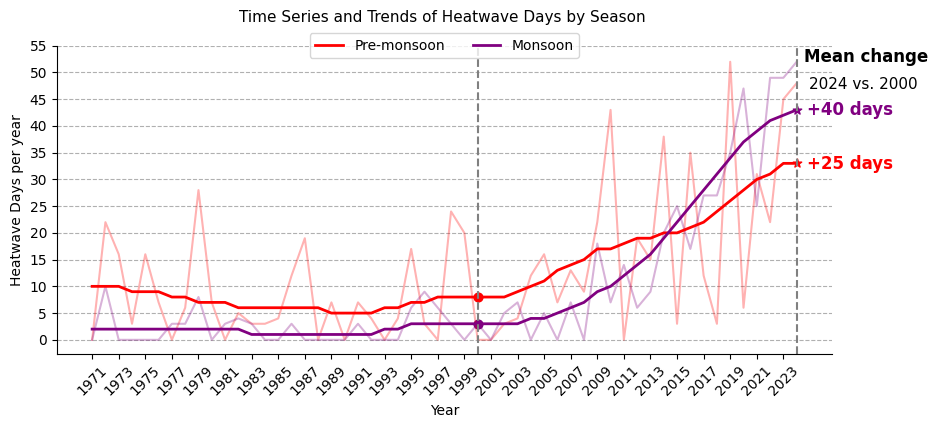

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal.windows import gaussian
from scipy.ndimage import convolve1d

# Specify the size of the figure (width, height) in inches
fig, ax = plt.subplots(figsize=(10, 4))

# Assuming yearly data is available
tickname = list(yearly_moonson['Year'])

x = np.arange(len(tickname))  # Create indices for the x-axis
y = np.arange(60)

y1 = yearly_pre_monsoon['Duration']
y2 = yearly_moonson['Duration']

#  Gaussian kernel
window_size = 20  # Length of the kernel
sigma = 3.5
gaussian_kernel = gaussian(window_size, std=sigma)
gaussian_kernel /= gaussian_kernel.sum()  # Normalize kernel

# Gaussian smoothing
smooth_y1 = convolve1d(y1, gaussian_kernel, mode='reflect')
smooth_y2 = convolve1d(y2, gaussian_kernel, mode='reflect')

# Plot the original data
ax.plot(tickname, y1, alpha=0.3, color='red')
ax.plot(tickname, y2, alpha=0.3, color='purple')

# Plot the smoothed data
ax.plot(tickname, smooth_y1, color='red', linewidth=2, label='Pre-monsoon')
ax.plot(tickname, smooth_y2, color='purple', linewidth=2, label='Monsoon')

# Adding a vertical line at the year 1980 and 2023
baseline=2000
endline=2024
ax.axvline(x=baseline, color='gray', linestyle='--', linewidth=1.5)
ax.axvline(x=endline, color='gray', linestyle='--', linewidth=1.5)

# Adding intersection points
ax.scatter(baseline, smooth_y1[baseline-1971], color='red', s=40)
ax.scatter(endline, smooth_y1[endline-1971], color='red', marker='*', s=40)
ax.scatter(baseline, smooth_y2[baseline-1971], color='purple', s=40)
ax.scatter(endline, smooth_y2[endline-1971], color='purple', marker='*', s=40)

# Calculating the difference between 2023 and 2000
pre_monsoon_rise = smooth_y1[endline-1971] - smooth_y1[baseline-1971]
monsoon_rise = smooth_y2[endline-1971] - smooth_y2[baseline-1971]

# text to highlight trends
ax.text(2028, 32, f'+{pre_monsoon_rise} days', fontsize=12, color='red', ha='center', fontweight='bold')
ax.text(2028, 42, f'+{monsoon_rise} days', fontsize=12, color='purple', ha='center', fontweight='bold')
ax.text(2029.2, 52, 'Mean change', fontsize=12, color='black', ha='center', fontweight='bold')
ax.text(2029, 47, f'{endline} vs. {baseline}', fontsize=11, color='black', ha='center')

# Removing top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# xticks and labels with rotation
ax.set_xticks(tickname[::2])
ax.set_xticklabels(tickname[::2], rotation=45)
# xticks and labels with rotation
yticks=np.arange(0,56)
ax.set_yticks(yticks[::5])
ax.set_yticklabels(yticks[::5])

# Display the legend (only for smoothed lines)
ax.legend(loc='center',bbox_to_anchor=(0.5, 1.0), fontsize=10,ncol=2)
ax.grid(axis='y', linestyle='--')

plt.xlabel('Year')
plt.ylabel('Heatwave Days per year')
plt.title('Time Series and Trends of Heatwave Days by Season',y=1.05,fontsize=11)
plt.show()

# Save the figure
fig.savefig("/content/drive/MyDrive/AP_HW/Scripts-ll/Manuscript codes/All_Figures/Fig_4_time_series_of_heatwave_days.jpg",
            dpi=300, format="jpg", bbox_inches="tight")